<a href="https://colab.research.google.com/github/neelkanthrawat/QBM_sept2022/blob/main/qbm_codes/qmcmc_trial_v0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [6]:
!pip install qiskit ipywidgets # while working on google colab!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 26.0 MB/s 
     |████████████████████████████████| 19.2 MB 1.2 MB/s 
     |████████████████████████████████| 240 kB 86.5 MB/s 
     |████████████████████████████████| 112 kB 69.6 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 8.1 MB/s 
     |████████████████████████████████| 943 kB 86.8 MB/s 
     |████████████████████████████████| 37.5 MB 69 kB/s 
     |████████████████████████████████| 1.6 MB 58.8 MB/s 
     |████████████████████████████████| 4.0 MB 66.2 MB/s 
     |████████████████████████████████| 112 kB 87.7 MB/s 
     |████████████████████████████████| 1.6 MB 72.2 MB/s 
  Created wheel for qiskit: filename=qiskit-0.38.0-py3-none-any.whl size=12147 sha256=42e87c1a1753b5f39b776fb96885332621d8b05990914b31599aebc5004a9ec5
  S

In [7]:
# while working on google colab, run this cell
!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils.py

--2022-10-05 05:57:34--  https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17062 (17K) [text/plain]
Saving to: ‘qbm_utils.py’

qbm_utils.py        100%[===================>]  16.66K  --.-KB/s    in 0s      

2022-10-05 05:57:34 (146 MB/s) - ‘qbm_utils.py’ saved [17062/17062]



In [8]:
from qbm_utils import *

### Define your model

In [9]:
# define the model
## put n_spins even always
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


### Some updated funcs

In [10]:
def classical_mcmc(N_hops:int, num_spins:int, num_elems:int, model, return_last_n_states=500, return_both_classical_and_quantum_steps=False ):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 

    ## initialiiise observables
    #observable_dict = dict([ (elem, []) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        states.append(current_state)
        # get sprime
        s_prime=classical_transition(num_spins)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state= next_state
        list_after_acceptance_step.append(current_state)
        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    
    # returns dictionary of occurences for last "return_last_n_states" states
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])
    
    if return_both_classical_and_quantum_steps: 
        to_return = dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
        to_return= dict_count_return_last_n_states 
    
    return to_return

In [11]:
def quantum_enhanced_mcmc(N_hops:int, num_spins:int, num_elems:int, model:IsingEnergyFunction, alpha, num_trotter_steps=10, return_last_n_states=500, return_both_classical_and_quantum_steps=False):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 
    ## initialise quantum circuit to current_state
    qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    #print("qc_s is:"); print(qc_s.draw())

    ## intialise observables
    #observable_dict = dict([ ( elem, []  ) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        #print("i: ", i)
        states.append(current_state)
        # get sprime
        s_prime=run_qc_quantum_step(qc_initialised_to_s=qc_s, model= model, alpha=alpha, n_spins=num_spins, num_trotter_steps=num_trotter_steps, time=0.8)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state=next_state
        # if current_state!=next_state:# this seems to be a redundant step. I could have set current_state=classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        #   current_state= next_state
        list_after_acceptance_step.append(current_state)

        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
      
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])#dictionary of occurences for last "return_last_n_states" states

    if return_both_classical_and_quantum_steps: 
      to_return= dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
      to_return= dict_count_return_last_n_states

    return to_return

### Some new helper functions

In [31]:
# some new helper functions
def states(num_spins:int)->list:
    ''' 
    Returns all possible binary strings of length n=num_spins

    Args:
    num_spins: n length of the bitstring
    Returns:
    possible_states= list of all possible binary strings of length num_spins
    '''
    num_possible_states=2**(num_spins)
    possible_states=[f'{k:0{num_spins}b}' for k in range(0,num_possible_states)]
    return possible_states

def magnetization_of_state(bitstring:str)->float:
    '''  
    Args:
    bitstring: for eg: '010'
    Returns:
    magnetization for the given bitstring
    '''
    array=np.array(list(bitstring))
    num_times_one=np.count_nonzero(array=='1')
    num_times_zero=len(array)-num_times_one
    magnetization=num_times_one-num_times_zero
    return magnetization

def dict_magnetization_of_all_states(list_all_possible_states:list)->dict:
    '''
    Returns magnetization for all unique states
    
    Args:
    list_all_possible_states
    Returns:
    dict_magnetization={state(str): magnetization_value}
    '''
    list_mag_vals=[magnetization_of_state(state) for state in list_all_possible_states]
    dict_magnetization=dict(zip(list_all_possible_states, list_mag_vals ))
    #print("dict_magnetization:"); print(dict_magnetization)
    return dict_magnetization
  
def value_sorted_dict(dict_in, reverse=False):

  sorted_dict={k: v for k, v in sorted(dict_in.items(), key=lambda item: item[1], reverse=reverse)}
  return sorted_dict


## enter samples, get normalised distn
def get_distn(list_of_samples:list)-> dict:
  '''   
  Returns the dictionary of distn for input list_of_samples
  '''
  len_list=len(list_of_samples)
  temp_dict=Counter(list_of_samples)
  temp_prob_list=np.array(list(temp_dict.values()))*(1./len_list)
  dict_to_return=dict(zip( list(temp_dict.keys()), temp_prob_list))
  return dict_to_return


## Average
def avg(dict_probabilities:dict, dict_observable_val_at_states:dict):
  ''' 
  Returns average of any observable of interest

  Args:
  dict_probabilities= {state: probability}
  dict_observable_val_at_states={state (same as that of dict_probabilities): observable's value at that state}

  Returns:
  avg
  '''
  len_dict=len(dict_probabilities)
  temp_array=np.zeros((len_dict,))
  temp_list=[dict_probabilities[j]*dict_observable_val_at_states[j] for j in (list(dict_probabilities.keys())) ]
  avg=np.mean(temp_list)
  return avg

### function to get running average of magnetization
def running_avg_magnetization(list_states_mcmc:list):
  ''' 
  Returns the running average magnetization 

  Args:
  list_states_mcmc= List of states aceepted after each MCMC step
  '''
  len_iters_mcmc=len(list_states_mcmc)
  running_avg_mag={}
  for i in tqdm(range(1,len_iters_mcmc)):
    temp_list=list_states_mcmc[:i]#[:i]
    temp_prob=get_distn(temp_list)
    dict_mag_states_in_temp_prob=dict_magnetization_of_all_states(temp_list)
    running_avg_mag[i]=avg(temp_prob, dict_mag_states_in_temp_prob)
  return running_avg_mag



## Plotting related
def plot_dict_of_running_avg_observable(dict_running_avg:dict, observable_legend_label:str):
  plt.plot(list(dict_running_avg.keys()), list(dict_running_avg.values()),"-" ,label=observable_legend_label)
  plt.xlabel("MCMC iterations")

def plot_bargraph_desc_order(desc_val_order_dict_in:dict, label:str, normalise_complete_data:bool=False,plot_first_few:int=0):
  width=1.0
  list_keys=list(desc_val_order_dict_in.keys())
  list_vals=list(desc_val_order_dict_in.values())
  if normalise_complete_data:
    list_vals=np.divide(list_vals, sum(list_vals))#np.divide(list(vals), sum(vals))
  if plot_first_few!=0:
    plt.bar(list_keys[0:plot_first_few], list_vals[0:plot_first_few], label=label)
  else:
    plt.bar(list_keys, list_vals, label=label)
  plt.xticks(rotation=45)

def plot_multiple_bargraphs(list_of_dicts:list,list_labels:list,list_normalise:list ,plot_first_few,  sort_desc=False,sort_asc=False, figsize=(15,7)):
  list_keys=list(list_of_dicts[0].keys())
  dict_data={}
  for i in range(0,len(list_labels)):
    #list_vals=[list_of_dicts[i][j] for j in list_keys if j in list(list_of_dicts[i].keys()) else 0] #list(list_of_dicts[i].values())
    list_vals=[list_of_dicts[i][j] if j in list(list_of_dicts[i].keys()) else 0 for j in list_keys]
    if list_normalise[i]:
      list_vals=np.divide(list_vals, sum(list_vals))
    dict_data[list_labels[i]]=list_vals
  df=pd.DataFrame(dict_data, index=list_keys)
  if sort_desc:
    df_sorted_desc=df.sort_values(list_labels[0], ascending=False)
    df_sorted_desc[:plot_first_few].plot.bar(rot=90,figsize=figsize)
  elif sort_asc:
    df_sorted_asc=df.sort_values(list_labels[0], ascending=True)
    df_sorted_asc[:plot_first_few].plot.bar(rot=90,figsize=figsize)
  elif (sort_desc==False and sort_asc==False):
    df[:plot_first_few].plot.bar(rot=90,figsize=figsize)


# function to create dict for number of times states sprime were not accepted in MCMC iterations
def fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept, bitstring):

  where_sprime_is_bitstr=list(np.where( np.array(list_after_trsn) == bitstring)[0])
  where_bitstr_not_accepted=[k for k in where_sprime_is_bitstr if list_after_accept[k]!=bitstring]
  numtimes_sprime_is_bitstring= len(where_sprime_is_bitstr)
  numtimes_bitstring_not_accepted=len(where_bitstr_not_accepted)
  return numtimes_bitstring_not_accepted, numtimes_sprime_is_bitstring

def fn_states_not_accepted(list_states:list, list_after_trsn:list, list_after_accept:list):
  list_numtimes_state_not_accepted=[fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept,k)[0] for k in list_states]
  list_numtimes_sprime_is_state=[fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept,k)[1] for k in list_states]
  dict_numtimes_states_not_accepted=dict(zip(list_states, list_numtimes_state_not_accepted))
  dict_numtimes_sprime_is_state=dict(zip(list_states, list_numtimes_sprime_is_state))
  return dict_numtimes_states_not_accepted, dict_numtimes_sprime_is_state

# hamming distance between 2 strings
def hamming_dist(str1, str2):
    i = 0
    count = 0
    while(i < len(str1)):
        if(str1[i] != str2[i]):
            count += 1
        i += 1
    return count


In [13]:
states_nbit=states(num_spins=n_spins)

# Actual_probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
rqd_sum=np.sum(np.array(list(transits_bltz.values())))
#print(rqd_sum)
prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
boltz_prob_distn=value_sorted_dict( dict(zip(states_nbit, prob_vals )), reverse=True )

## Run classical MCMC

In [44]:
def hamming_dist_related_counts(num_spins:int,sprime_each_iter:list, states_accepted_each_iter:list):

  dict_counts_states_hamming_dist=dict(zip(list(range(0,num_spins+1)), [0]*(num_spins+1) ))
  ham_dist_s_and_sprime=np.array([hamming_dist(states_accepted_each_iter[j], sprime_each_iter[j+1]) for j in range(0,len(states_accepted_each_iter)-1) ])
  for k in list(dict_counts_states_hamming_dist.keys()):
    dict_counts_states_hamming_dist[k]=np.count_nonzero(ham_dist_s_and_sprime == k) 
  
  assert sum(list(dict_counts_states_hamming_dist.values()))== len(sprime_each_iter)-1
  return dict_counts_states_hamming_dist

def energy_difference_related_counts(num_spins, sprime_each_iter:list, states_accepted_each_iter:list, model_in):

  energy_diff_s_and_sprime=np.array([abs(model.get_energy(sprime_each_iter[j])-model.get_energy(states_accepted_each_iter[j])) for j in range(0,len(states_accepted_each_iter)-1)])
  return energy_diff_s_and_sprime

In [ ]:
# symmetric uniform transition matrix for uniform transition rule
num_spins=n_spins#4
num_elems=2**(num_spins)
# transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
# np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=2000
dict_seperate_chains_states_distn_mcmc={}
dict_seperate_chains_sprime_mcmc={}
dict_seperate_chains_accepted_mcmc={}
dict_seperate_chains_counts_based_on_hamming_dist={}
dict_seperate_chain_energy_diff_s_and_sprime={}# for plotting histogram
num_seperate_mcmc_chains=10

for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
    dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =classical_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=600, return_both_classical_and_quantum_steps=True)
    dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)

    dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
    dict_seperate_chains_sprime_mcmc[chain_num]=cl_mcmc_after_trsn
    dict_seperate_chains_accepted_mcmc[chain_num]=cl_mcmc_after_accept
    dict_seperate_chain_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept, model_in=model)
    dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept)

In [ ]:
### data for plotting running average magnetization 5 cases seperately:
first_few=500
#cl_running_avg_magzn=[running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc[m][:first_few+1]) for m in range(0,num_seperate_mcmc_chains)]
dict_for_df_running_avg_seperate_mcmc={}
for m in range(0, num_seperate_mcmc_chains):
  dict_for_df_running_avg_seperate_mcmc[m]=list(running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc[m][:first_few+1]).values())

running_avg_df=pd.DataFrame(dict_for_df_running_avg_seperate_mcmc)
mean_magnetization=running_avg_df.mean(axis=1)# mean taken over all seperate mcmc chains

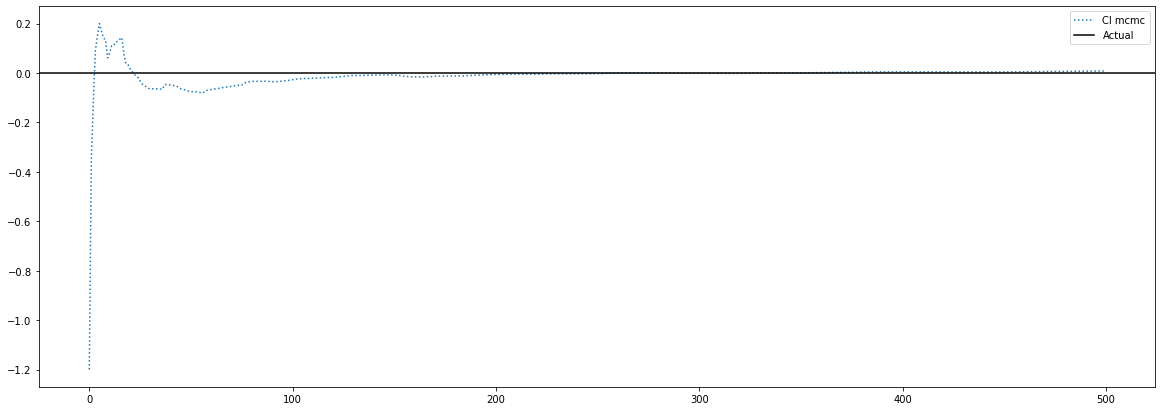

In [63]:
plt.figure(figsize=(20,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.plot(mean_magnetization,":" ,label="Cl mcmc")
plt.axhline(y=actual_avg_mag,linestyle="-", color="k" ,label="Actual")
plt.legend()

In [49]:
### Sampling related
# not needed
# list_of_dict_state_not_accepted=[]
# list_of_dict_sprime_occured=[]
# for i in tqdm(range(0,num_seperate_mcmc_chains)):
#     dict_numtimes_state_not_accepted, dict_numtimes_sprime=fn_states_not_accepted(list_states=states_nbit,
#     list_after_trsn=dict_seperate_chains_sprime_mcmc[i], 
#     list_after_accept= dict_seperate_chains_accepted_mcmc[i])
#     list_of_dict_state_not_accepted.append(dict_numtimes_state_not_accepted)
#     list_of_dict_sprime_occured.append(dict_numtimes_sprime)

# numtimes_sprime_rejected_array=np.zeros((num_elems,num_seperate_mcmc_chains))
# numtimes_sprime_occured_array=np.zeros((num_elems,num_seperate_mcmc_chains))
# for i in range(0, num_seperate_mcmc_chains):
#     numtimes_sprime_rejected_array[:,i]=list(list_of_dict_state_not_accepted[i].values())
#     numtimes_sprime_occured_array[:,i]=list(list_of_dict_sprime_occured[i].values())

# avg_sprime_rejected=list(np.mean(numtimes_sprime_rejected_array, axis=1))
# std_dev_sprime_rejected=np.std(numtimes_sprime_rejected_array, axis=1)
# avg_sprime_occured=list(np.mean(numtimes_sprime_occured_array, axis=1))

# dict_avg_times_sprime_rejected=dict(
#     zip(
#     list(dict_numtimes_state_not_accepted.keys()),avg_sprime_rejected
#     )
#     )

# dict_avg_times_sprime_occured=dict(
#     zip(
#     list(dict_numtimes_sprime.keys()),avg_sprime_occured
#     )
#     )

# print(avg_sprime_rejected)

In [ ]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,1,1)
# plot_bargraph_desc_order(boltz_prob_distn,label="theoretical", plot_first_few=30)   
# plt.legend()
# plt.subplot(2,1,2)
# plot_bargraph_desc_order(dict_states_mcmc,label="MCMC-uniform", normalise_complete_data=True)  
# plt.legend()
# # plot_bargraph(boltz_prob_distn,label="theoretical",plot_first_few=60)  
# # plot_bargraph(dict_states_mcmc,label="MCMC-Uniform",normalise_complete_data=True,plot_first_few=60)  
# plot_multiple_bargraphs([boltz_prob_distn,dict_states_mcmc], ["theory", "MCMC-Uniform random"], list_normalise=[True,True], plot_first_few=30, sort_desc=True)
# # plt.legend()

In [ ]:
# # get actual probability distribution
# transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
# # plot actual prob distribution as well as one obtained from MCMC
# #dict_states_mcmc_plot=dict(zip(list(range(0,2**(num_spins))), list(dict_states_mcmc.values()) ))
# plot_histogram( [boltz_prob_distn, dict_states_mcmc] , figsize=(20, 7), legend= ['model', 'MCMC-uniform'], bar_labels=False, sort="value_desc")

## Run quantum enhanced MCMC

In [ ]:
# symmetric uniform transition matrix for uniform transition rule: tho tbh I dont need it
num_spins=n_spins#4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=600
dict_states_quantum_mcmc, quant_mcmc_after_trsn, quant_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, 
num_spins, num_elems, model, alpha, num_trotter_steps=10, 
return_last_n_states=300,return_both_classical_and_quantum_steps=True)

starting with:  00011101


100%|██████████| 600/600 [03:59<00:00,  2.51it/s]


In [ ]:
# get actual probability distribution
#transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
# plot actual prob distribution as well as one obtained from MCMC
plot_histogram( [boltz_prob_distn, dict_states_quantum_mcmc] , figsize=(20, 7), legend= ['model', 'Quantum-enhanced MCMC' ], sort= 'value_desc')

In [ ]:
fig = plot_histogram( [boltz_prob_distn,dict_states_quantum_mcmc] , figsize=(40, 15), legend= ["model", "Quantum" ], bar_labels=False)
fig

In [ ]:
plot_histogram( [boltz_prob_distn,dict_states_mcmc, dict_states_quantum_mcmc] , figsize=(40, 15), legend= ['model', 'classical MCMC: Uniform','Quantum-enhanced MCMC' ], sort='value_desc', bar_labels=False)

In [ ]:
# transits_bltz

In [ ]:
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
rqd_sum=np.sum(np.array(list(transits_bltz.values())))
#print(rqd_sum)
prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
boltz_prob_distn=dict(zip(list(transits_bltz.keys()), prob_vals ))
print(boltz_prob_distn)

### comparing number of accepted/rejected samples

In [ ]:
# plt.figure(figsize=(20,7))
# plt.plot(cl_mcmc_after_trsn, label="Classical Uniform")
# plt.plot(quant_mcmc_after_trsn, label="Quantum")
# plt.xlabel("MCMC iterations")
# plt.title("after transition")
plt.figure(figsize=(10,10))
#quant_mcmc_after_trsn, quant_mcmc_after_accept
plt.plot(cl_mcmc_after_accept, label="Classical Uniform")
plt.plot(quant_mcmc_after_accept,label="Quantum")
plt.xlabel("MCMC iterations")
plt.title("State accepted in i'th iteration")
plt.legend()

Next task:
For different problem instances, do the following:

1. Running average: magnetization. **(DONE)**

2.  For first few relevant states (high probability), check how many times were those states accepted/rejected out of total number of iterations considered for the prob distn. **(CODE IS COMPLETE, NOW WE NEED TO RUN SOME EXPERIEMENTS)**

3. Overlap with the desired distribution.


## Running average; magnetization

In [ ]:
check_cl=running_avg_magnetization(list_states_mcmc=cl_mcmc_after_accept)
check_quant=running_avg_magnetization(list_states_mcmc=quant_mcmc_after_accept)

100%|██████████| 599/599 [00:00<00:00, 811.41it/s]


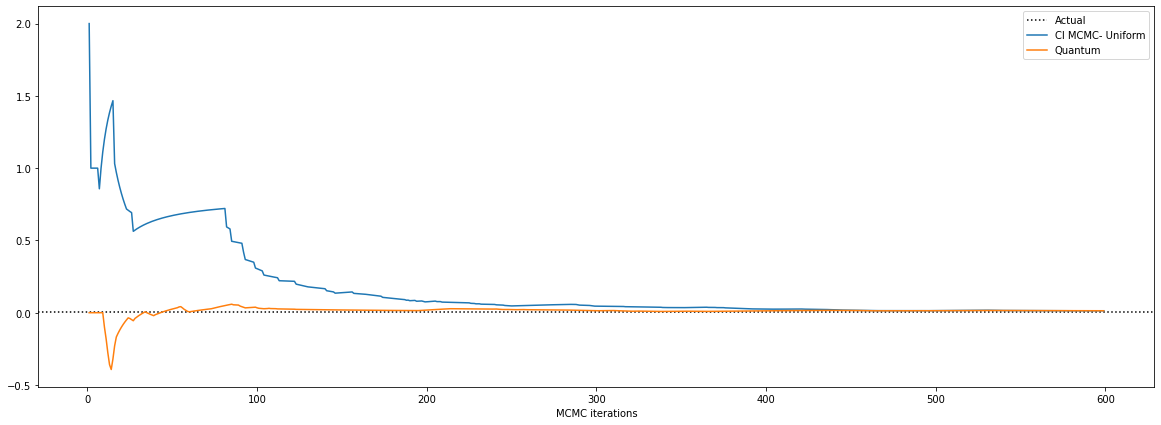

In [ ]:
plt.figure(figsize=(20,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.axhline(y=actual_avg_mag,linestyle=":", color="k" ,label="Actual")
plot_dict_of_running_avg_observable(check_cl, "Cl MCMC- Uniform")
plot_dict_of_running_avg_observable(check_quant, "Quantum")
plt.legend()

## Sampling related

In [ ]:
# cl_mcmc_after_trsn, cl_mcmc_after_accept
# quant_mcmc_after_trsn, quant_mcmc_after_accept 
aa,bb=fn_states_not_accepted(list_states=states_nbit, list_after_trsn=cl_mcmc_after_trsn, list_after_accept=cl_mcmc_after_accept)
print(aa); print(bb)
# fn_numtimes_bitstring_not_accepted(list_after_trsn=cl_mcmc_after_trsn, list_after_accept=cl_mcmc_after_accept,bitstring='0000')